In [30]:
import sagemaker
import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.session import s3_input, Session
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
     

In [3]:
bucket_name = 'titanic19' # <--- CHANGE THIS VARIABLE TO A UNIQUE NAME FOR YOUR BUCKET
my_region = boto3.session.Session().region_name # set the region of the instance
print(my_region)

us-east-1


In [4]:
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
        s3.create_bucket(Bucket=bucket_name)
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

S3 bucket created successfully


In [5]:

# set an output path where the trained model will be saved
prefix = 'xgboost-as-a-built-in-algo'
output_path ='s3://{}/{}/output'.format(bucket_name, prefix)
print(output_path)

s3://titanic19/xgboost-as-a-built-in-algo/output


In [6]:

import pandas as pd
import urllib
try:
    urllib.request.urlretrieve ("https://d1.awsstatic.com/tmt/build-train-deploy-machine-learning-model-sagemaker/bank_clean.27f01fbbdf43271788427f3682996ae29ceca05d.csv", "bank_clean.csv")
    print('Success: downloaded bank_clean.csv.')
except Exception as e:
    print('Data load error: ',e)

try:
    model_data = pd.read_csv('./bank_clean.csv',index_col=0)
    print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Data load error: ',e)

Success: downloaded bank_clean.csv.
Success: Data loaded into dataframe.


In [7]:
import numpy as np
train_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data))])
print(train_data.shape, test_data.shape)

(28831, 61) (12357, 61)


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [8]:
model_data

,age,campaign,pdays,previous,no_previous_contact,not_working,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,...,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_no,y_yes
0,56,1,999,0,1,0,0,0,0,1,...,0,1,0,0,0,0,1,0,1,0
1,57,1,999,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
2,37,1,999,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
3,40,1,999,0,1,0,1,0,0,0,...,0,1,0,0,0,0,1,0,1,0
4,56,1,999,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,1,999,0,1,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
41184,46,1,999,0,1,0,0,1,0,0,...,1,0,0,0,0,0,1,0,1,0
41185,56,2,999,0,1,1,0,0,0,0,...,1,0,0,0,0,0,1,0,1,0
41186,44,1,999,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1


In [10]:
### Saving Train And Test Into Buckets
## We start with Train Data
import os
pd.concat([train_data['y_yes'], train_data.drop(['y_no', 'y_yes'], 
                                                axis=1)], 
                                                axis=1).to_csv('train.csv', index=False, header=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
s3_input_train = sagemaker.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

In [11]:
# Test Data Into Buckets
pd.concat([test_data['y_yes'], test_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('test.csv', index=False, header=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')
s3_input_test = sagemaker.TrainingInput(s3_data='s3://{}/{}/test'.format(bucket_name, prefix), content_type='csv')

In [12]:
s3_input_test

Building Models Xgboot- Inbuilt Algorithm

In [19]:
# this line automatically image_urilooks for the XGBoost image URI and builds an XGBoost container.
# specify the repo_version depending on your preference.
container = get_image_uri(boto3.Session().region_name,
                          'xgboost', 
                          repo_version='1.0-1')

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [14]:
# initialize hyperparameters
hyperparameters = {
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"4",
        "min_child_weight":"6",
        "subsample":"0.7",
        "objective":"binary:logistic",
        "num_round":50
        }
     

In [20]:
# construct a SageMaker estimator that calls the xgboost-container
estimator = sagemaker.estimator.Estimator(image_uri =container, 
                                          hyperparameters=hyperparameters,
                                          role=sagemaker.get_execution_role(),
                                          train_instance_count=1, 
                                          train_instance_type='ml.m5.2xlarge', 
                                          train_volume_size=5, # 5 GB 
                                          output_path=output_path,
                                          train_use_spot_instances=True,
                                          train_max_run=300,
                                          train_max_wait=600)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_use_spot_instances has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_wait has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_volume_size has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [22]:

estimator.fit({'train': s3_input_train,'validation': s3_input_test})

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-09-08-06-49-31-954


2024-09-08 06:49:33 Starting - Starting the training job...
2024-09-08 06:49:47 Starting - Preparing the instances for training...
2024-09-08 06:50:15 Downloading - Downloading input data...
2024-09-08 06:51:07 Training - Training image download completed. Training in progress....
2024-09-08 06:51:32 Uploading - Uploading generated training model[2024-09-08 06:51:24.798 ip-10-2-99-86.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined deli

In [23]:
xgb_predictor = estimator.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-09-08-06-53-37-600
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2024-09-08-06-53-37-600
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2024-09-08-06-53-37-600


------!

Prediction of the Test Data

In [25]:
from sagemaker.serializers import CSVSerializer

# Prepare the test data
test_data_array = test_data.drop(['y_no', 'y_yes'], axis=1).values  # Load the data into an array

# Configure the predictor
xgb_predictor.content_type = 'text/csv'  # Set the data type for an inference
xgb_predictor.serializer = CSVSerializer()  # Set the serializer type

# Perform the prediction
predictions = xgb_predictor.predict(test_data_array).decode('utf-8')  # Predict!

# Turn the prediction into an array
predictions_array = np.fromstring(predictions[1:], sep=',')  

# Print the shape of the predictions array
print(predictions_array.shape)


(12357,)


In [26]:

predictions_array

array([0.05214286, 0.05660191, 0.05096195, ..., 0.03436061, 0.02942475,
       0.03715819])

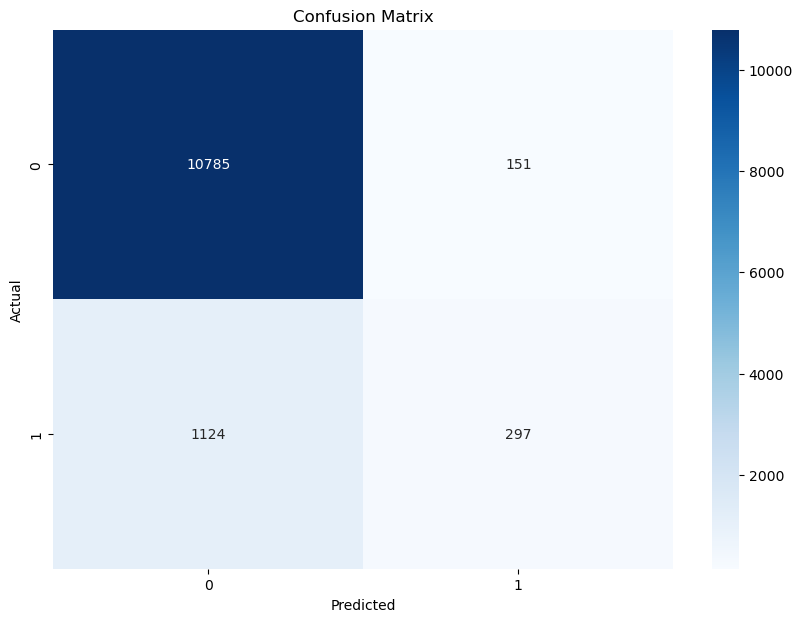

In [28]:
actual_labels = test_data['y_yes'].values

# Generate confusion matrix
cm = confusion_matrix(actual_labels, predictions_array.round())  # Round predictions if they are probabilities

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [29]:
cm = pd.crosstab(index=test_data['y_yes'], columns=np.round(predictions_array), rownames=['Observed'], colnames=['Predicted'])
tn = cm.iloc[0,0]; fn = cm.iloc[1,0]; tp = cm.iloc[1,1]; fp = cm.iloc[0,1]; p = (tp+tn)/(tp+tn+fp+fn)*100
print("\n{0:<20}{1:<4.1f}%\n".format("Overall Classification Rate: ", p))
print("{0:<15}{1:<15}{2:>8}".format("Predicted", "No Purchase", "Purchase"))
print("Observed")
print("{0:<15}{1:<2.0f}% ({2:<}){3:>6.0f}% ({4:<})".format("No Purchase", tn/(tn+fn)*100,tn, fp/(tp+fp)*100, fp))
print("{0:<16}{1:<1.0f}% ({2:<}){3:>7.0f}% ({4:<}) \n".format("Purchase", fn/(tn+fn)*100,fn, tp/(tp+fp)*100, tp))
     


Overall Classification Rate: 89.7%

Predicted      No Purchase    Purchase
Observed
No Purchase    91% (10785)    34% (151)
Purchase        9% (1124)     66% (297) 



In [31]:
precision = precision_score(actual_labels, predictions_array.round())
recall = recall_score(actual_labels, predictions_array.round())
accuracy = accuracy_score(actual_labels, predictions_array.round())
f1 = f1_score(actual_labels, predictions_array.round())

# Display metrics
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')

Precision: 0.6629464285714286
Recall: 0.20900774102744546
Accuracy: 0.8968196164117505
F1 Score: 0.31781701444622795


In [32]:

sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)
bucket_to_delete = boto3.resource('s3').Bucket(bucket_name)
bucket_to_delete.objects.all().delete()
     

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Deleting endpoint with name: sagemaker-xgboost-2024-09-08-06-53-37-600


[{'ResponseMetadata': {'RequestId': '9V2CT66FHYPT2Z1P',
   'HostId': 'qyS4b1wfjZ3eD8nzQPLwuMp1jaxlO6E6fpaiqYmF/C6Zufqto3jzGNI6aAH0UReUGgPWBs7XbbZi0m5WdM3u6nYXWh6Iqj6mHywuXvLk0VQ=',
   'HTTPStatusCode': 200,
   'HTTPHeaders': {'x-amz-id-2': 'qyS4b1wfjZ3eD8nzQPLwuMp1jaxlO6E6fpaiqYmF/C6Zufqto3jzGNI6aAH0UReUGgPWBs7XbbZi0m5WdM3u6nYXWh6Iqj6mHywuXvLk0VQ=',
    'x-amz-request-id': '9V2CT66FHYPT2Z1P',
    'date': 'Sun, 08 Sep 2024 07:05:38 GMT',
    'content-type': 'application/xml',
    'transfer-encoding': 'chunked',
    'server': 'AmazonS3',
    'connection': 'close'},
   'RetryAttempts': 0},
  'Deleted': [{'Key': 'xgboost-as-a-built-in-algo/output/sagemaker-xgboost-2024-09-08-06-49-31-954/debug-output/events/000000000020/000000000020_worker_0.tfevents'},
   {'Key': 'xgboost-as-a-built-in-algo/test/test.csv'},
   {'Key': 'xgboost-as-a-built-in-algo/output/sagemaker-xgboost-2024-09-08-06-49-31-954/profiler-output/system/incremental/2024090806/1725778200.algo-1.json'},
   {'Key': 'xgboost-as-a